In [ ]:
!pip install MDAnalysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.0 MB/s eta 0:00:00


In [ ]:
# Стандартное отображение трехбуквенных кодов аминокислот на однобуквенные
AA_CODES = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}

In [ ]:
# --- Импорты ---
import MDAnalysis as mda
import MDAnalysis.lib.util as mda_util
from MDAnalysis.lib import distances as lib_distances
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
# Стандартное отображение трехбуквенных кодов аминокислот на однобуквенные
AA_CODES = {
    'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
    'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
    'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
    'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y'
}

In [ ]:
# --- Функция анализа и построения графика ---
def analyze_and_plot_colab(tpr_file, xtc_file, peptide_sel="protein", ligand_sel="resname LIG", cutoff=3.5, graph_title = "pept+lig"):
    print(f"Загрузка системы: {tpr_file}, {xtc_file}")
    if not os.path.exists(tpr_file) or not os.path.exists(xtc_file):
        print("Ошибка: TPR или XTC файл не найден в указанном пути Colab.")
        return

    u = mda.Universe(tpr_file, xtc_file, progress_meter=True)
    print("Выбор групп атомов...")
    peptide_atoms = u.select_atoms(peptide_sel)
    ligand_atoms = u.select_atoms(ligand_sel)

    if len(peptide_atoms) == 0:
        print(f"Ошибка: Не найдены атомы для селектора пептида: '{peptide_sel}'")
        return
    if len(ligand_atoms) == 0:
        print(f"Ошибка: Не найдены атомы для селектора лиганда: '{ligand_sel}'")
        return

    peptide_residues = peptide_atoms.residues
    num_peptide_residues = len(peptide_residues)
    num_frames = len(u.trajectory)

    peptide_resid_labels = [f"{AA_CODES.get(res.resname, res.resname[0])}{res.resid}" for res in peptide_residues]
    print(f"Обнаружено {num_peptide_residues} остатков пептида.")
    print(f"Обнаружено {num_frames} кадров в траектории.")

    # --- Анализ контактов ---
    print(f"Начинаем анализ контактов (порог = {cutoff} Å)...")
    contact_matrix = np.zeros((num_peptide_residues, num_frames), dtype=np.int8)

    for ts_idx, ts in enumerate(u.trajectory):
        if (ts_idx + 1) % (num_frames // 20 or 1) == 0:
            progress = (ts_idx + 1) / num_frames * 100


        ligand_pos = ligand_atoms.positions
        for res_idx, residue in enumerate(peptide_residues):
            ref_positions = residue.atoms.positions
            config_positions = ligand_pos
            pairs = lib_distances.capped_distance(ref_positions,
                                                  config_positions,
                                                  max_cutoff=cutoff,
                                                  box=u.dimensions,
                                                  return_distances=False)
            if len(pairs) > 0:
                contact_matrix[res_idx, ts_idx] = 1



    # --- Построение графика ---
    print("Строим карту контактов...")
    dt = u.trajectory.dt  # Шаг времени в ps
    time_points_ns = np.arange(num_frames) * dt / 1000.0  # Переводим в ns

    fig, ax = plt.subplots(figsize=(12, 7))
    im = ax.imshow(contact_matrix, aspect='auto', cmap=plt.cm.Greens, vmin=0, vmax=1.2,
                   origin='lower', extent=[time_points_ns[0], time_points_ns[-1], -0.5, num_peptide_residues - 0.5])
    ax.set_yticks(np.arange(num_peptide_residues))
    ax.set_yticklabels(peptide_resid_labels)
    ax.set_xlabel("Время, нс")
    ax.set_ylabel("Номер остатка")
    ax.set_title(graph_title)
    plt.tight_layout()
    plt.show()

Загрузка системы: /content/pept1+lig1_prod.tpr, /content/pept1+lig1_prod.xtc
Выбор групп атомов...
Обнаружено 13 остатков пептида.
Обнаружено 201 кадров в траектории.
Начинаем анализ контактов (порог = 3.5 Å)...
Строим карту контактов...


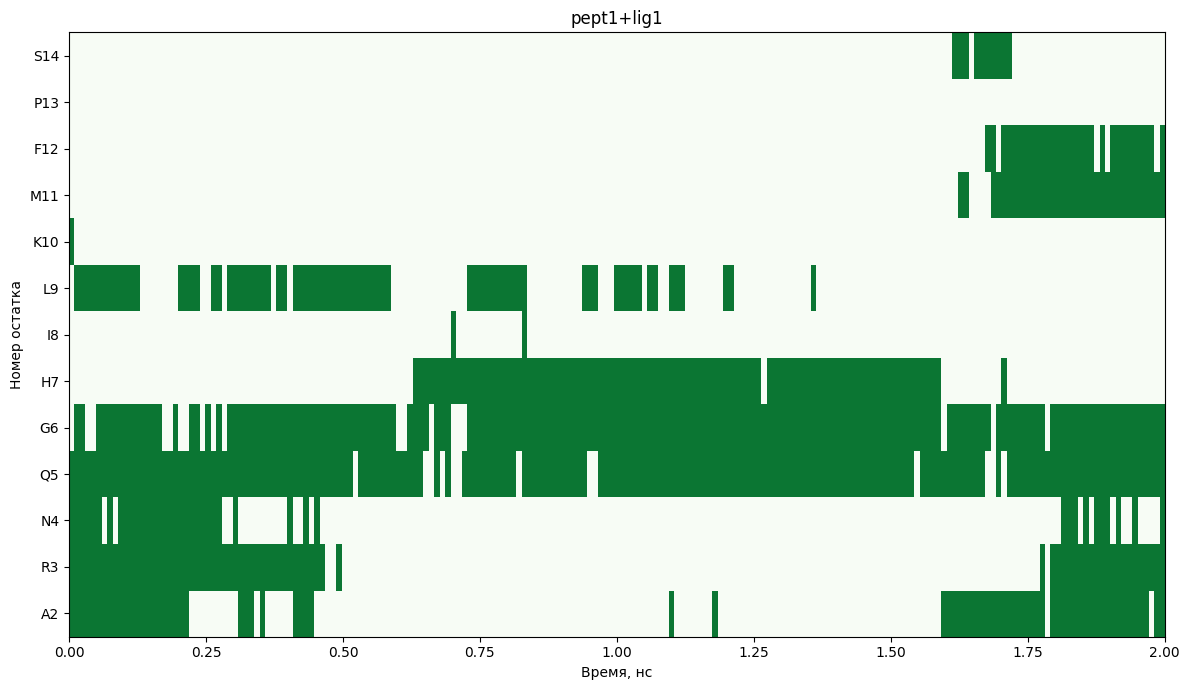

In [ ]:
# --- Запуск анализа для pept1+lig1 ---
analyze_and_plot_colab('/content/pept1+lig1_prod.tpr',
                       '/content/pept1+lig1_prod.xtc',
                       ligand_sel = "resname AAY",
                       graph_title = "pept1+lig1")

Загрузка системы: /content/pept1+lig2_prod.tpr, /content/pept1+lig2_prod.xtc
Выбор групп атомов...
Обнаружено 13 остатков пептида.
Обнаружено 201 кадров в траектории.
Начинаем анализ контактов (порог = 3.5 Å)...
Строим карту контактов...


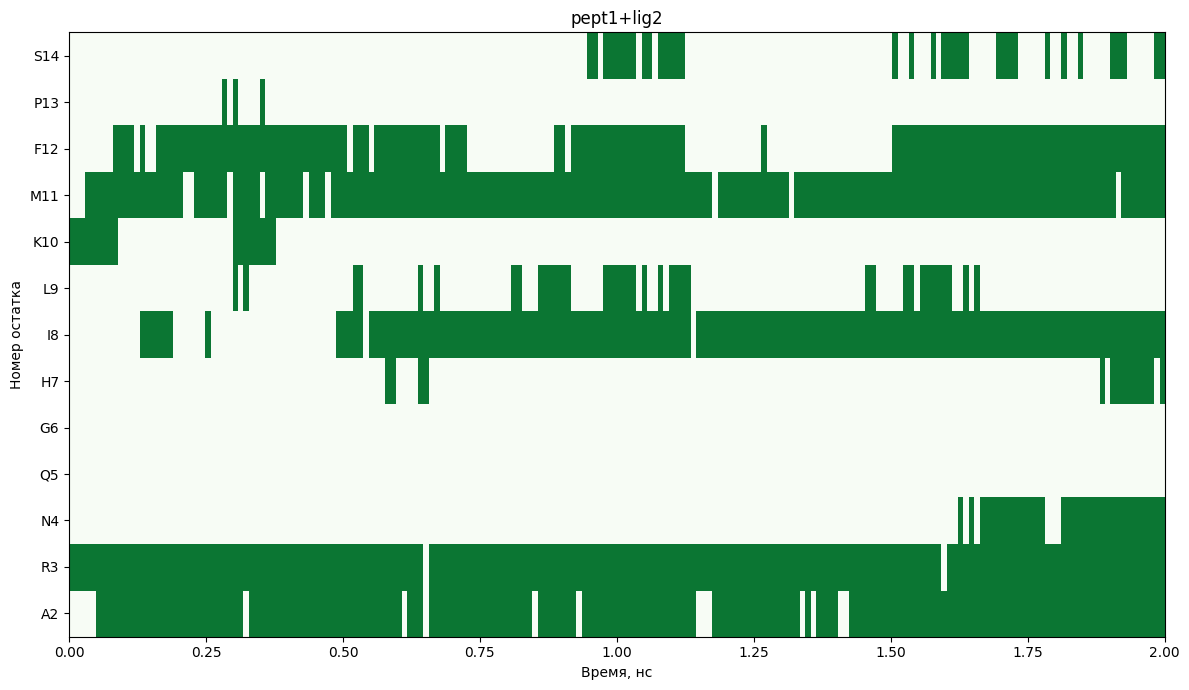

In [ ]:
# --- Запуск анализа для pept1+lig2 ---
analyze_and_plot_colab('/content/pept1+lig2_prod.tpr',
                       '/content/pept1+lig2_prod.xtc',
                       ligand_sel = "resname M2O",
                       graph_title = "pept1+lig2")

Загрузка системы: /content/pept2+lig1_prod.tpr, /content/pept2+lig1_prod.xtc
Выбор групп атомов...
Обнаружено 13 остатков пептида.
Обнаружено 201 кадров в траектории.
Начинаем анализ контактов (порог = 3.5 Å)...
Строим карту контактов...


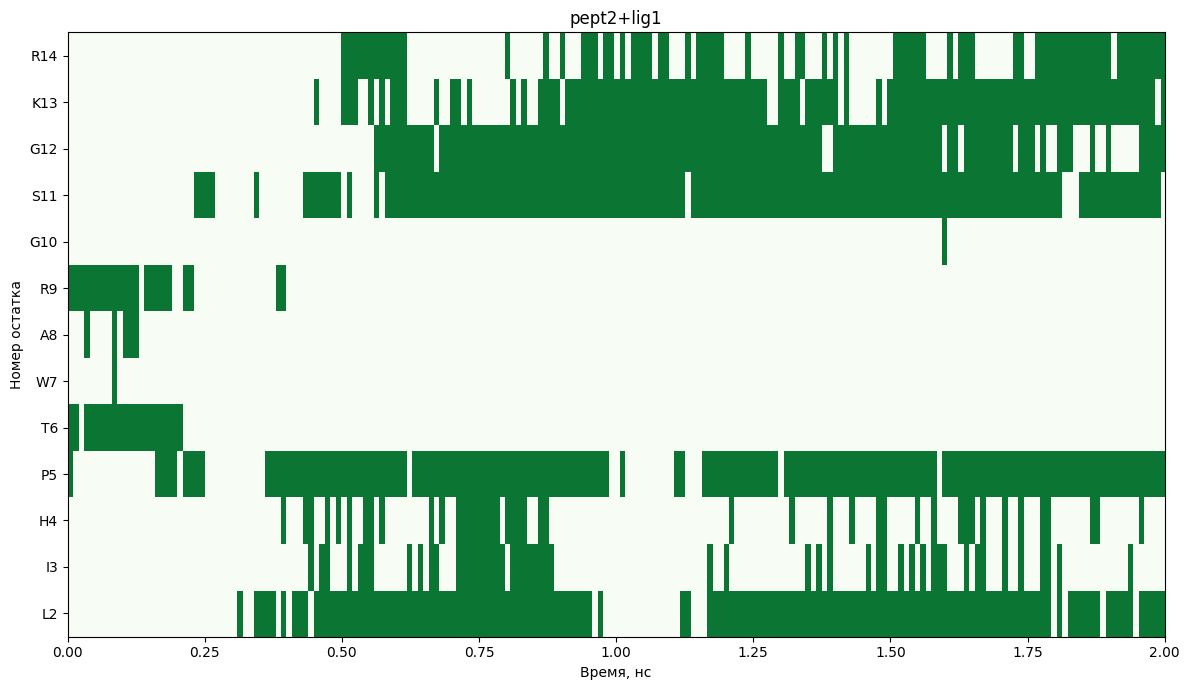

In [ ]:
# --- Запуск анализа для pept2+lig1 ---
analyze_and_plot_colab('/content/pept2+lig1_prod.tpr',
                       '/content/pept2+lig1_prod.xtc',
                       ligand_sel = "resname AAY",
                       graph_title = "pept2+lig1")

Загрузка системы: /content/pept2+lig2_prod.tpr, /content/pept2+lig2_prod.xtc


/usr/local/lib/python3.11/dist-packages/MDAnalysis/coordinates/XDR.py:253: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn(


Выбор групп атомов...
Обнаружено 13 остатков пептида.
Обнаружено 201 кадров в траектории.
Начинаем анализ контактов (порог = 3.5 Å)...
Строим карту контактов...


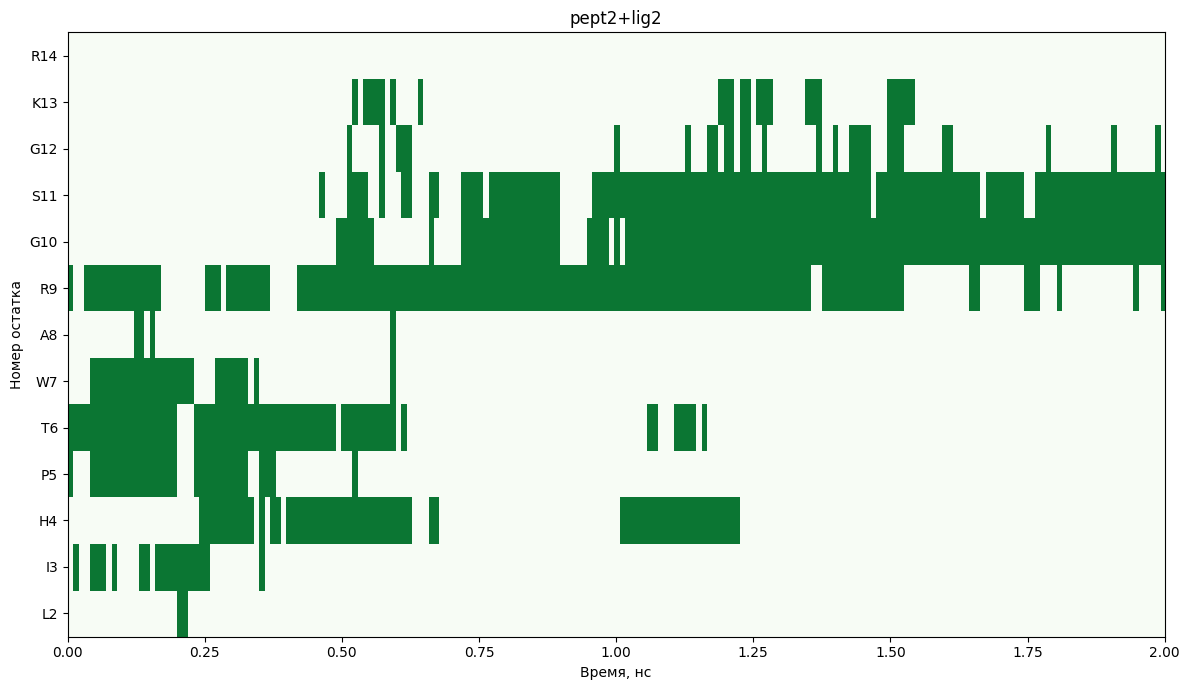

In [ ]:
# --- Запуск анализа для pept2+lig1 ---
analyze_and_plot_colab('/content/pept2+lig2_prod.tpr',
                       '/content/pept2+lig2_prod.xtc',
                       ligand_sel = "resname M2O",
                       graph_title = "pept2+lig2")

## Лабораторный журнал: МД симуляция пептид-лиганд (pept1 + Хлорамфеникол)

**Дата:** 08.04.2025

**Система:** pept1 (Циклический пептид) + lig1 (Хлорамфеникол)

**Цель:** Провести МД симуляцию взаимодействия пептида с лигандом в водном растворе с ионами для последующего анализа контактов.

**Программное обеспечение и окружение:**>

*   **Окружение Conda:** `gmx`
*   **GROMACS:** 2024.5 (установлен из `conda-forge` с поддержкой CUDA и OpenMPI, команда `gmx_mpi`)
*   **AmberTools:** (Установлен как зависимость или отдельно в окружении `gmx`, использовались `antechamber`, `parmchk2`, `tleap`)
*   **ACPYPE:** 2023.10.27 (Использовался для конвертации AMBER -> GROMACS)
*   **Open Babel:** (Использовался для конвертации PDB -> MOL2)
*   **Python 3.x:** (с библиотеками `MDAnalysis`, `matplotlib`, `numpy`, `argparse`)
*   **ОС:** Linux (через WSL)
*   **GPU:** NVIDIA RTX 4060 (использовалась для ускорения MD)

---

**Этап 1: Подготовка исходных файлов**

1.  **Пептид:** Исходная структура циклического пептида (Ala-Arg-Asn-Gln-Gly-His-Ile-Leu-Lys-Met-Phe-Pro-Ser) предоставлена в файле `pept1.pdb` (предполагается, что циклизация уже учтена в структуре или будет учтена на следующем шаге).
2.  **Лиганд:** Исходная структура Хлорамфеникола (оптимизированная QM) получена с ATB и сохранена как `lig1.pdb`.

---

**Этап 2: Подготовка топологии и координат пептида (GROMACS)**

1.  **Генерация топологии GROMACS:** С помощью `pdb2gmx` созданы файлы топологии (`.top`), координат (`.gro`) и позиционных ограничений (`posre.itp`) для пептида, используя силовое поле AMBER14SB и модель воды TIP3P.
    ```bash
    gmx_mpi pdb2gmx -f pept1.pdb -o pept1.gro -p pept1.top -ignh -ff amber14sb -water tip3p
    ```
    *   **Результат:** `pept1.gro`, `pept1.top`, `posre.itp`.
    *   **Примечание:** На этом этапе требовалось убедиться, что цикличность пептида корректно отражена в `pept1.top` (например, через добавление связи между N- и C-концами в `[ bonds ]` и удаление соответствующих терминирующих групп). Также файл `posre.itp` был сгенерирован автоматически.

2.  **Переименование файла ограничений:** Сгенерированный файл `posre.itp` переименован для ясности.
    ```bash
    mv posre.itp posre_protein.itp
    ```
    *   **Результат:** `posre_protein.itp`.

3.  **Включение файла ограничений в топологию пептида:** Файл `pept1.top` был отредактирован вручную. Строка `#include "posre.itp"` внутри блока `#ifdef POSRES` (который был добавлен `pdb2gmx`) была заменена на:
    ```itp
    #include "posre_protein.itp"
    ```
*_Для удобства лучше применить поиск по документу в pept1.top, в nano при помощи Ctrl+W и затем написать POSRES, или в блокноте на Windows при помощи строенного поиска_

---

**Этап 3: Оптимизация геометрии пептида (Отжиг)**

1.  **Создание бокса:** Создан кубический бокс вокруг пептида с отступом 1.0 нм.
    ```bash
    gmx_mpi editconf -f pept1.gro -o pept1_box.gro -c -d 1.0 -bt cubic
    ```
    *   **Результат:** `pept1_box.gro`.

2.  **Создание MDP файла для отжига (`anneal.mdp`)** Создан файл `anneal.mdp` со следующими параметрами: (нужно создать файл при anneal.mdp при помощи nano в терминале или вручную в интерфейсе винды например, со следующим содержанием):
```bash
integrator      = md
nsteps          = 5000
dt              = 0.001
nstxout-compressed  = 1000 ; Сохраняем чаще для короткого теста (каждые 1 ps)
nstlog          = 1000
nstenergy       = 1000
xtc-precision   = 1000
constraints     = h-bonds
constraint_algorithm = LINCS
cutoff-scheme   = Verlet
nstlist         = 10
rcoulomb        = 1.0
rvdw            = 1.0
DispCorr        = EnerPres
coulombtype     = PME
pme_order       = 4
fourierspacing  = 0.16
tcoupl          = V-rescale
tc-grps         = System
tau_t           = 0.1
ref_t           = 400
pcoupl          = Berendsen
pcoupltype      = isotropic
tau_p           = 2.0
ref_p           = 1.0
compressibility = 4.5e-5
annealing       = single
annealing-npoints = 3
annealing-time  = 0 2.5 5
annealing-temp  = 5 400 400
gen_vel         = yes
gen_temp        = 5
gen_seed        = -1
pbc             = xyz
```
3.  **Запуск `grompp` для отжига:**
    ```bash
    gmx_mpi grompp -f anneal.mdp -c pept1_box.gro -p pept1.top -o pept1_anneal.tpr -maxwarn 2
    ```
    *   **Результат:** `pept1_anneal.tpr`.

4.  **Запуск `mdrun` для отжига:**
    ```bash
    gmx_mpi mdrun -deffnm pept1_anneal -v
    ```
    *   **Результат:** `pept1_anneal.log`, `pept1_anneal.xtc`, `pept1_anneal.edr`, `pept1_anneal.gro`, `pept1_anneal.cpt`.

5.  **Извлечение оптимизированной структуры:** Последний кадр траектории отжига (500 пс) извлечен.
    ```bash
    echo "0" | gmx_mpi trjconv -s pept1_anneal.tpr -f pept1_anneal.xtc -o pept1_optimized.gro -dump 500
    ```
    *   **Результат:** `pept1_optimized.gro`.

---

**Этап 4: Параметризация лиганда (Обход ACPYPE)**

*Примечание: Прямой запуск `acpype` с BCC зарядами не удался из-за ошибки `sqm`. Был выполнен ручной процесс с использованием AmberTools.*

1.  **Конвертация PDB в MOL2:**
    ```bash
    obabel lig1.pdb -O lig1.mol2
    ```
    *   **Результат:** `lig1.mol2`.

2.  **Запуск `antechamber`:** Назначены типы атомов GAFF2 и рассчитаны BCC заряды.
    ```bash
    antechamber -i lig1.mol2 -fi mol2 -o lig1_gaff2.mol2 -fo mol2 -c bcc -nc 0 -at gaff2 -s 2
    ```
    *   **Результат:** `lig1_gaff2.mol2` (с типами и зарядами), `ANTECHAMBER_*` файлы, `sqm.in`, `sqm.out`.

3.  **Запуск `parmchk2`:** Найдены недостающие параметры для силового поля GAFF2.
    ```bash
    parmchk2 -i lig1_gaff2.mol2 -f mol2 -o lig1.frcmod
    ```
    *   **Результат:** `lig1.frcmod`.

4.  **Создание скрипта `tleap.in`** (далее нужно создать файл tleap.in, с помощью nano или блокнота винды и поместить в него следующее содержание):
    ```tleap
    source leaprc.gaff2
    loadamberparams lig1.frcmod
    lig = loadmol2 lig1_gaff2.mol2
    saveamberparm lig lig1.prmtop lig1.inpcrd
    quit
    ```

5.  **Запуск `tleap`:** Собраны файлы топологии и координат в формате AMBER.
    ```bash
    tleap -f tleap.in
    ```
    *   **Результат:** `lig1.prmtop`, `lig1.inpcrd`, `leap.log`.

6.  **Конвертация AMBER -> GROMACS:** Использован `acpype` только для конвертации.
    ```bash
    acpype -p lig1.prmtop -x lig1.inpcrd -b lig1_bcc_manual -k amber
    ```
    *   **Результат:** Создана директория `lig1_bcc_manual.amb2gmx`.

7.  **Извлечение файлов GROMACS:**
    *   Из файла `lig1_bcc_manual.amb2gmx/lig1_bcc_manual_GMX.top` была скопирована секция `[ moleculetype ]` (включая `[ atoms ]`, `[ bonds ]` и т.д.) и вставлена в новый файл `lig1_bcc_manual.itp` в основной директории.
    *   Файл `lig1_bcc_manual.amb2gmx/lig1_bcc_manual_GMX.gro` скопирован в основную директорию как `lig1_bcc_manual_GMX.gro`.
    *   Файл `lig1_bcc_manual.amb2gmx/posre_lig1_bcc_manual.itp` скопирован в основную директорию как `posre_lig1_bcc_manual.itp`.

8.  **Включение файла ограничений в топологию лиганда:** Файл `lig1_bcc_manual.itp` отредактирован вручную, в конец добавлен блок:
    ```itp
    ; Include Position restraint file for ligand
    #ifdef POSRES
    #include "posre_lig1_bcc_manual.itp"
    #endif
    ```

---

**Этап 4.А: Подготовка определений типов атомов GAFF2**

1.  **Поиск/Извлечение определений:** После выполнения конвертации AMBER -> GROMACS с помощью `acpype` (Шаг 4.6) был проверен файл `lig1_bcc_manual.amb2gmx/lig1_bcc_manual_GMX.top`. В начале этого файла **не было** обнаружено строки `#include "ffnonbonded.itp"` или аналогичной. Вместо этого, секция `[ atomtypes ]`, содержащая определения для типов атомов GAFF2, используемых в лиганде (`cl`, `c3`, `h2`, `c`, `o`, `ns`, `hn`, `h1`, `oh`, `ho`, `ca`, `ha`, `no`), **присутствовала непосредственно внутри** файла `lig1_bcc_manual.amb2gmx/lig1_bcc_manual_GMX.top`.

2.  **Копирование определений:** Вся секция `[ atomtypes ]` была скопирована из файла `lig1_bcc_manual.amb2gmx/lig1_bcc_manual_GMX.top` **_(далее идет как эта секция должна выглядеть внутри lig1_bcc_manual_GMX.top, цифры скорее всего будут такие же, но на всякий случай лучше брать не отсюда, а взять из имеющегося в директории файла):_**
    ```itp
    [ atomtypes ]
    ;name   bond_type     mass     charge   ptype   sigma         epsilon       Amb
     cl       cl          0.00000  0.00000   A     3.46595e-01   1.10374e+00 ; 1.95  0.2638
     c3       c3          0.00000  0.00000   A     3.39771e-01   4.51035e-01 ; 1.91  0.1078
     h2       h2          0.00000  0.00000   A     2.24382e-01   8.70272e-02 ; 1.26  0.0208
     c        c           0.00000  0.00000   A     3.31521e-01   4.13379e-01 ; 1.86  0.0988
     o        o           0.00000  0.00000   A     3.04812e-01   6.12119e-01 ; 1.71  0.1463
     ns       ns          0.00000  0.00000   A     3.25000e-01   7.11280e-01 ; 1.82  0.1700
     hn       hn          0.00000  0.00000   A     1.10650e-01   4.18400e-02 ; 0.62  0.0100
     h1       h1          0.00000  0.00000   A     2.42200e-01   8.70272e-02 ; 1.36  0.0208
     oh       oh          0.00000  0.00000   A     3.24287e-01   3.89112e-01 ; 1.82  0.0930
     ho       ho          0.00000  0.00000   A     5.37925e-02   1.96648e-02 ; 0.30  0.0047
     ca       ca          0.00000  0.00000   A     3.31521e-01   4.13379e-01 ; 1.86  0.0988
     ha       ha          0.00000  0.00000   A     2.62548e-01   6.73624e-02 ; 1.47  0.0161
     no       no          0.00000  0.00000   A     3.36510e-01   3.58987e-01 ; 1.89  0.0858
    ```

3.  **Вставка в основную топологию:** Эта скопированная секция `[ atomtypes ]` была **вставлена** в основной файл топологии пептида **`pept1.top`** сразу **после** строки `#include "amber14sb.ff/forcefield.itp"`.

4. **Сразу после** вставленной секции [atomtypes] добавляем строчку
```bash
 #include "lig1_bcc_manual.itp"
```
---

**Этап 5: Сборка системы (Пептид + Лиганд + Вода + Ионы)**

**Цель:** Создать симуляционный бокс, содержащий одну молекулу оптимизированного пептида, одну молекулу лиганда, молекулы воды и ионы для нейтрализации и достижения физиологической концентрации соли.

**Исходные файлы:**

*   `pept1_optimized.gro` (координаты пептида после отжига, Этап 3)
*   `pept1.top` (топология пептида, включая цикличность, определения типов атомов GAFF2 из Этапа 4.А, и блок `#ifdef POSRES` для `posre_protein.itp`)
*   `lig1_bcc_manual_GMX.gro` (координаты лиганда, Этап 4)
*   `lig1_bcc_manual.itp` (топология лиганда, включая блок `#ifdef POSRES` для `posre_lig1_bcc_manual.itp`, Этап 4)

**Выполненные шаги и команды:**

1.  **Комбинирование пептида и лиганда, создание бокса:** Пептид центрирован во временном боксе, лиганд вставлен со случайным смещением, затем создан финальный кубический бокс с расстоянием 2.0 нм от любой молекулы до края.
    ```bash
    gmx_mpi editconf -f pept1_optimized.gro -o pept1_center.gro -c -box 6.0 6.0 6.0
    gmx_mpi insert-molecules -f pept1_center.gro -ci lig1_bcc_manual_GMX.gro -nmol 1 -o pept1_lig1_bcc_manual_combined.gro -try 50 -radius 0.2 -dr 1.0 1.0 1.0
    gmx_mpi editconf -f pept1_lig1_bcc_manual_combined.gro -o pept1_lig1_bcc_manual_box.gro -c -d 2.0 -bt cubic
    ```
    *   **Результат:** `pept1_lig1_bcc_manual_box.gro` (координаты пептида и лиганда в боксе).


2.  **Сольватация:** Система помещена в растворитель (модель воды TIP3P).
    ```bash
    gmx_mpi solvate -cp pept1_lig1_bcc_manual_box.gro -cs spc216.gro -o pept1_lig1_bcc_manual_solv.gro -p pept1.top
    ```

    *   **Результат:** `pept1_lig1_bcc_manual_solv.gro` (координаты пептида, лиганда и воды). Команда также автоматически **добавила** строку `SOL XXXXX` (где XXXXX - число добавленных молекул воды, например, 19900) в конец секции `[ molecules ]` файла `pept1.top`.


3.  **Добавление ионов:** Добавлены ионы Na+ и Cl- для нейтрализации общего заряда системы (+2 от пептида) и доведения концентрации соли до 0.15 М.
    *   Создан файл `ions.mdp`:
        ```bash
        printf "integrator = md\nnsteps = 0\n" > ions.mdp
        ```
    *   Запуск `grompp` для подготовки к добавлению ионов:
        ```bash
        gmx_mpi grompp -f ions.mdp -c pept1_lig1_bcc_manual_solv.gro -p pept1.top -o pept1_lig1_bcc_manual_ions.tpr -maxwarn 5
        ```
    *   Запуск `genion` для замены молекул воды ионами:
        ```bash
        echo "SOL" | gmx_mpi genion -s pept1_lig1_bcc_manual_ions.tpr -o pept1_lig1_bcc_manual_solv_ions.gro -p pept1.top -pname NA -nname CL -neutral -conc 0.15
        ```
    *   **Результат:** `pept1_lig1_bcc_manual_solv_ions.gro` (финальные координаты системы). Команда `genion` также автоматически **обновила** секцию `[ molecules ]` в `pept1.top`, добавив строки для `NA` и `CL` и скорректировав число `SOL`.


**Финальные файлы Этапа 5 (готовы для Этапа 6):**

*   **Координаты:** `pept1_lig1_bcc_manual_solv_ions.gro`
*   **Топология:** `pept1.top` (содержит силовое поле, типы GAFF2, включение `.itp` лиганда, определения пептида и лиганда с PosRe, включение воды/ионов, финальную секцию `[ molecules ]`)

---

**Этап 6: Создание индексного файла**

1.  **Запуск `make_ndx`:** Индексный файл создан для финальной системы.
    ```bash
    gmx_mpi make_ndx -f pept1_lig1_bcc_manual_solv_ions.gro -o index_updated.ndx
    ```
2.  **Интерактивные команды внутри `make_ndx`:**
    *   `5 | 2` (Enter) -> Объединение групп Protein (5) и AAY (2). Создана группа 23 `Protein_AAY`.
    *   `q` (Enter) -> Сохранение и выход.
3.  **Переименование:**
    ```bash
    mv index_updated.ndx index.ndx
    ```
    *   **Результат:** `index.ndx` с группами `Protein_AAY` и `Water_and_ions`.

---

**Этап 7: Подготовка и запуск МД симуляций (Минимизация, Уравновешивание, Продакшен)**

1.  **Создание MDP файлов:** Созданы файлы:
    *   `step6.1_minimization.mdp` **_(создаем вручную, при помощи блокнота или nano несколько файлов. Сначала нужно создать step6.1_minimization.mdp):_**

    ```bash
    ; --- Параметры для минимизации энергии ---
    title           = Energy Minimization
    integrator      = steep         ; Алгоритм: Steepest Descent (хорошо для начала)
    nsteps          = 5000          ; Максимальное число шагов минимизации
    emtol           = 1000.0        ; Завершить, если макс. сила < 1000 kJ/mol/nm
    emstep          = 0.01          ; Начальный размер шага (nm)
    ; Параметры для соседей, обрезки и PME (нужны для grompp)
    cutoff-scheme   = Verlet
    ns_type         = grid
    nstlist         = 10
    rcoulomb        = 1.2           ; Обрезка для Кулона
    rvdw            = 1.2           ; Обрезка для Ван-дер-Ваальса
    pbc             = xyz           ; Периодические условия во всех направлениях
    coulombtype     = PME           ; Электростатика PME
    ```   

    **_(далее так же создаем)_**

    *   `step6.2_equilibration_nvt.mdp`:

    ```bash
    ; --- Параметры для NVT уравновешивания ---
    title           = NVT Equilibration
    define          = -DPOSRES      ; Включаем позиционные ограничения (см. ниже!)
    integrator      = md            ; Алгоритм: Leap-frog MD
    nsteps          = 50000         ; Время: 100 ps (50000 шагов * 0.002 ps/шаг)
    dt              = 0.002         ; Шаг интегрирования 2 fs
    ; Вывод
    nstxout-compressed  = 5000      ; Сохранять координаты каждые 10 ps
    nstlog          = 5000      ; Писать в лог каждые 10 ps
    nstenergy       = 5000      ; Сохранять энергии каждые 10 ps
    ; Связи
    constraints     = h-bonds       ; Ограничиваем связи с H (для шага 2 fs)
    constraint_algorithm = LINCS
    ; Обрезки и соседи
    cutoff-scheme   = Verlet
    ns_type         = grid
    nstlist         = 20            ; Чаще обновляем список соседей
    rcoulomb        = 1.2
    rvdw            = 1.2
    DispCorr        = EnerPres
    ; Электростатика PME
    coulombtype     = PME
    pme_order       = 4
    fourierspacing  = 0.16
    ; Температура (V-rescale) - раздельные группы для лучшего контроля
    tcoupl          = V-rescale
    tc-grps         = Protein_AAY Water_and_ions
    tau_t           = 0.1           0.1         ; Время связи (ps)
    ref_t           = 300           300         ; Целевая температура (K)
    ; Давление - НЕТ (NVT ансамбль)
    pcoupl          = no
    ; Начальные скорости
    gen_vel         = yes           ; Генерировать скорости из распр. Максвелла
    gen_temp        = 300           ; Температура для генерации
    gen_seed        = -1            ; Случайное число
    ; PBC
    pbc             = xyz
    ```

    *   `step6.3_equilibration_npt.mdp`: **_(для теста nsteps 5000, если нужно запустить это как настоящую симуляцию, поставить нужно nsteps 500000):_**

    ```bash
    ; --- Параметры для NPT уравновешивания ---
    title           = NPT Equilibration
    define          = -DPOSRES      ; ПОЗИЦИОННЫЕ ОГРАНИЧЕНИЯ ВСЕ ЕЩЕ ВКЛЮЧЕНЫ!
    integrator      = md
    nsteps          = 5000        ; Время: 500 ps (500000 * 0.001 ps/шаг) - как в PDF
    dt              = 0.001         ; Шаг 1 fs для стабильности с баростатом в начале
    ; Вывод (можно реже, чем в NVT)
    nstxout-compressed  = 5000      ; Сохранять координаты каждые 5 ps
    nstlog          = 5000
    nstenergy       = 5000
    ; Связи
    constraints     = h-bonds
    constraint_algorithm = LINCS
    ; Обрезки, PME и т.д. - как в NVT
    cutoff-scheme   = Verlet
    ns_type         = grid
    nstlist         = 20
    rcoulomb        = 1.2
    rvdw            = 1.2
    DispCorr        = EnerPres
    coulombtype     = PME
    pme_order       = 4
    fourierspacing  = 0.16
    ; Температура (как в NVT)
    tcoupl          = V-rescale
    tc-grps         = Protein_AAY Water_and_ions
    tau_t           = 0.1           0.1
    ref_t           = 300           300
    ; Давление (Parrinello-Rahman - хороший выбор)
    pcoupl          = Parrinello-Rahman
    pcoupltype      = isotropic     ; Изотропное давление
    tau_p           = 2.0           ; Время связи (ps)
    ref_p           = 1.0           ; Целевое давление (bar)
    compressibility = 4.5e-5        ; Сжимаемость воды
    ; Начальные скорости - НЕТ, продолжаем с NVT
    gen_vel         = no
    continuation    = yes           ; Продолжаем с предыдущего этапа
    ; PBC
    pbc             = xyz
    ```
    *   `step6.4_production.mdp`: **_(для теста nsteps 1000000, если нужно запустить это как настоящую симуляцию, поставить нужно nsteps 100000000):_**

    ```bash
    ; --- Параметры для продуктивной МД (200 нс) ---
    title           = Production MD (200 ns)
    ; define        =                ; ПОЗИЦИОННЫЕ ОГРАНИЧЕНИЯ ВЫКЛЮЧЕНЫ! (закомментировано или удалено)
    integrator      = md
    nsteps          = 1000000     ; Время: 200 ns (100,000,000 * 0.002 ps/шаг)
    dt              = 0.002         ; Шаг 2 fs
    ; Вывод (частота зависит от нужд анализа)
    nstxout-compressed  = 5000      ; Сохранять координаты каждые 10 ps (5000 * 2 fs)
    nstlog          = 5000      ; Писать в лог каждые 10 ps
    nstenergy       = 5000      ; Сохранять энергии каждые 10 ps
    nstvout         = 0             ; Скорости не сохраняем часто
    nstfout         = 0             ; Силы не сохраняем часто
    ; Связи
    constraints     = h-bonds
    constraint_algorithm = LINCS
    ; Обрезки, PME и т.д. - как в NPT
    cutoff-scheme   = Verlet
    ns_type         = grid
    nstlist         = 20
    rcoulomb        = 1.2
    rvdw            = 1.2
    DispCorr        = EnerPres
    coulombtype     = PME
    pme_order       = 4
    fourierspacing  = 0.16
    ; Температура (как в NPT)
    tcoupl          = V-rescale
    tc-grps         = Protein_AAY Water_and_ions
    tau_t           = 0.1           0.1
    ref_t           = 300           300
    ; Давление (как в NPT)
    pcoupl          = Parrinello-Rahman
    pcoupltype      = isotropic
    tau_p           = 2.0
    ref_p           = 1.0
    compressibility = 4.5e-5
    ; Начало и продолжение
    gen_vel         = no
    continuation    = yes           ; Продолжаем с NPT
    ; PBC
    pbc             = xyz
    ```

2.  **Запуск симуляций:** Выполнен скрипт `step6_query.sh`, содержащий последовательные вызовы `gmx_mpi grompp` и `gmx_mpi mdrun` для каждого этапа.
    *   **Минимизация:**
        ```bash
        gmx_mpi grompp -f step6.1_minimization.mdp -c pept1_lig1_bcc_manual_solv_ions.gro -p pept1.top -o pept1_lig1_bcc_manual_min.tpr -maxwarn 5
        gmx_mpi mdrun -deffnm pept1_lig1_bcc_manual_min -v -nb gpu # PME на CPU
        ```
    *   **NVT Уравновешивание:**
        ```bash
        gmx_mpi grompp -f step6.2_equilibration_nvt.mdp -c pept1_lig1_bcc_manual_min.gro -r pept1_lig1_bcc_manual_min.gro -p pept1.top -n index.ndx -o pept1_lig1_bcc_manual_nvt.tpr -maxwarn 5
        gmx_mpi mdrun -deffnm pept1_lig1_bcc_manual_nvt -v -nb gpu -pme gpu # GPU
        ```
    *   **NPT Уравновешивание:**
        ```bash
        gmx_mpi grompp -f step6.3_equilibration_npt.mdp -c pept1_lig1_bcc_manual_nvt.gro -r pept1_lig1_bcc_manual_nvt.gro -t pept1_lig1_bcc_manual_nvt.cpt -p pept1.top -n index.ndx -o pept1_lig1_bcc_manual_npt.tpr -maxwarn 5
        gmx_mpi mdrun -deffnm pept1_lig1_bcc_manual_npt -v -nb gpu -pme gpu # GPU
        ```
    *   **Продуктивная МД:**
        ```bash
        gmx_mpi grompp -f step6.4_production.mdp -c pept1_lig1_bcc_manual_npt.gro -t pept1_lig1_bcc_manual_npt.cpt -p pept1.top -n index.ndx -o pept1_lig1_bcc_manual_prod.tpr -maxwarn 5
        gmx_mpi mdrun -deffnm pept1_lig1_bcc_manual_prod -v -nb gpu -pme gpu # GPU
        ```
    *   **Результат:** Набор файлов `.log`, `.xtc`, `.edr`, `.tpr`, `.gro`, `.cpt` для каждого этапа, включая финальную траекторию `pept1_lig1_bcc_manual_prod.xtc`.

---

**Этап 8: Очистка ненужных файлов (Опционально)**

*   Удалены файлы бэкапов (`#*#`).
*   Удалены промежуточные файлы `antechamber`, `sqm`, `tleap`, `obabel`, AMBER (`.frcmod`, `.inpcrd`, `.prmtop`).
*   Удалены промежуточные файлы отжига (`pept1_anneal.*`, `pept1_box.gro`).
*   Удалены промежуточные файлы сборки (`pept1_center.gro`, `..._combined.gro`, `..._box.gro`, `..._solv.gro`, `ions.mdp`).
*   Удалена директория `lig1_bcc_manual.amb2gmx` (после извлечения `.itp` и `.gro`).

---

**Этап 9: Подготовка к анализу**

*   Финальная траектория: `pept1_lig1_bcc_manual_prod.xtc`.
*   Файл топологии/структуры для анализа: `pept1_lig1_bcc_manual_prod.tpr`.
*   Подготовлен Python скрипт (`analyze_contacts.py`) для расчета карты контактов с использованием MDAnalysis.
*   Определены селекторы для анализа: `-psel protein`, `-lsel "resname AAY"`.
*   Порог для контактов: `-cutoff 3.5` (Ангстрем).

---

**Статус:** Система успешно отсимулирована на 200 нс. Файлы готовы для выполнения скрипта анализа контактов.

*__P.S.__ В конкретно этой работе были выставлены только 1000000 шагов, что соответствует 2 наносекундам*